# Emotion Detection

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG,Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.16.1


### Exploring Dataset

**Preparing Data for training**

In [3]:
img_size=48
batch_size=64
datagen_train= ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size= (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size= (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle = True)
                                                    
                                                

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [5]:
# in the same way we will define dense layers
def Dense_f(input_tensor,nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [6]:
#as our dataset is fer so we are writing our function as model fer 
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(7,activation = "softmax")(dense_1)
    model= Model(inputs= [inputs], outputs = [output])

    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [7]:
# next we see how is our model
model = model_fer((48,48,1))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the Model**

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//train_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

### Training the Model

**The next cell takes time to complete**

In [9]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)    

Epoch 1/15


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.3275 - loss: 1.8573
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 300s 660ms/step - accuracy: 0.3276 - loss: 1.8568 - val_accuracy: 0.3608 - val_loss: 1.6259
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:12 431ms/step - accuracy: 0.3125 - loss: 1.5897
Epoch 2: saving model to model.weights.h5


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3125 - loss: 1.5897 - val_accuracy: 0.2000 - val_loss: 1.8175
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4871 - loss: 1.3573
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 198s 441ms/step - accuracy: 0.4871 - loss: 1.3573 - val_accuracy: 0.3891 - val_loss: 1.5331
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:09 423ms/step - accuracy: 0.3906 - loss: 1.5846
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3906 - loss: 1.5846 - val_accuracy: 0.4000 - val_loss: 1.3783
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.5581 - loss: 1.1750
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 202s 450ms/step - accuracy: 0.5580 - loss: 1.1750 - val_accuracy: 0.4003 - val_loss: 1.5626
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:13 432ms/step - accuracy: 0.5000 - loss: 1.3232
Epoch 6: saving model to model.weights.h5


**Model Evaluation**

In [10]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.4558 - loss: 1.6590


[1.6344599723815918, 0.4595987796783447]

**Plotting Loss**

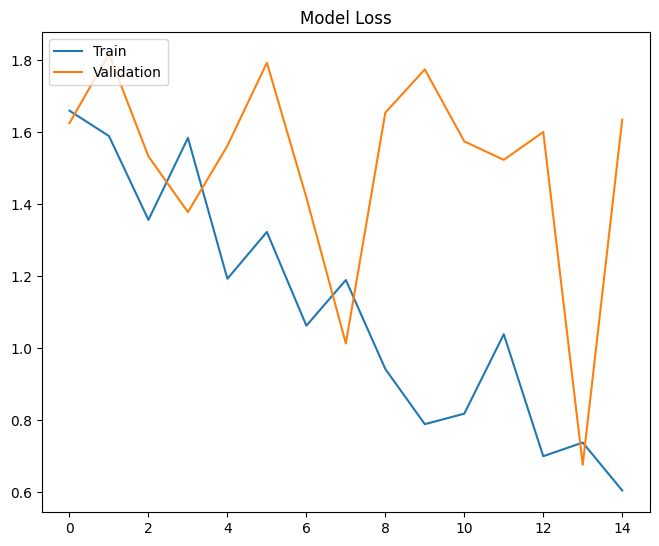

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

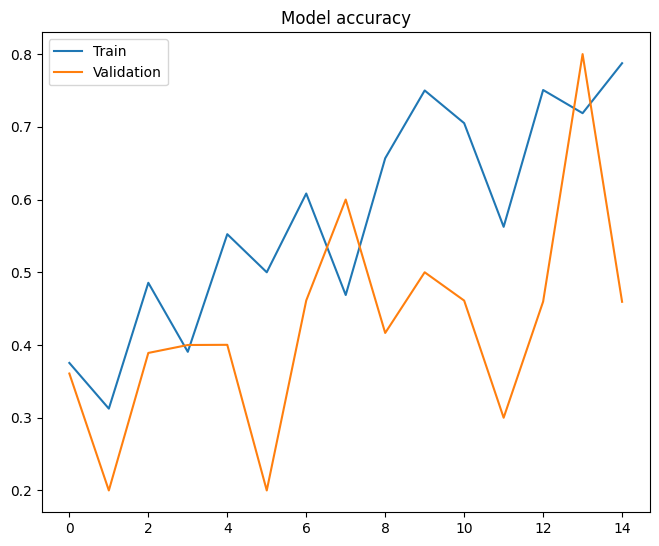

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [13]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)